In [1]:
import pandas as pd
import numpy as np

loadData = pd.read_csv("eeg_data.csv")
data = np.array(loadData)

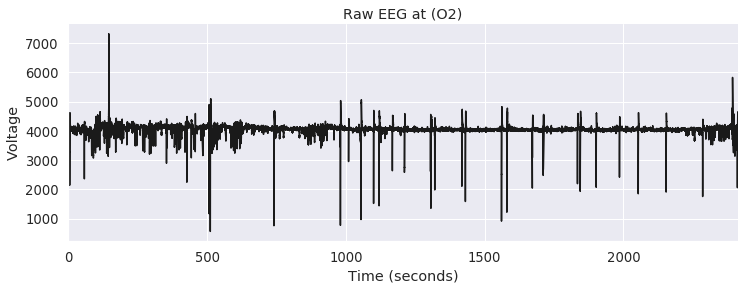

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.2)

ED_O2 = data[:,7]

# Define sampling frequency and time vector
sf = 128.
time = np.arange(ED_O2.size) / sf

# Plot the signal
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
plt.plot(time, ED_O2, lw=1.5, color='k')
plt.xlabel('Time (seconds)')
plt.ylabel('Voltage')
plt.xlim([time.min(), time.max()])
plt.title('Raw EEG at (O2)')
sns.despine()

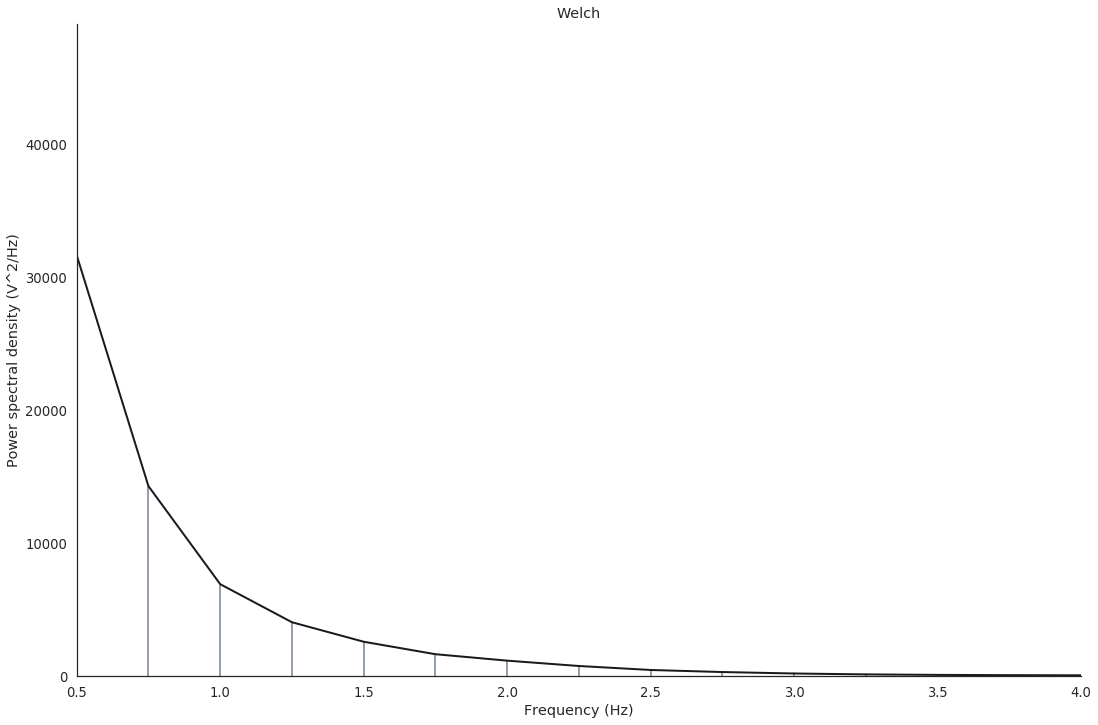

In [4]:
def plot_spectrum(data, sf, window_sec, band=None, dB=False):
    """Plot the periodogram, Welch's and multitaper PSD.

    Requires MNE-Python >= 0.14.

    Parameters
    ----------
    data : 1d-array
        Input signal in the time-domain.
    sf : float
        Sampling frequency of the data.
    band : list
        Lower and upper frequencies of the band of interest.
    window_sec : float
        Length of each window in seconds for Welch's PSD
    dB : boolean
        If True, convert the power to dB.
    """
    from scipy.signal import welch
    sns.set(style="white", font_scale=1.2)
    # Compute the PSD
    freqs_welch, psd_welch = welch(data, sf, nperseg=window_sec*sf)
    sharey = False

    # Optional: convert power to decibels (dB = 10 * log10(power))
    if dB:
        psd_welch = 10 * np.log10(psd_welch)
        sharey = True

    # Start plot
    fig, ax = plt.subplots(1, 1, figsize=(18, 12), sharex=True, sharey=sharey)
    # Stem
    sc = 'slategrey'
    ax.stem(freqs_welch, psd_welch, linefmt=sc, basefmt=" ", markerfmt=" ")
    # Line
    lc, lw = 'k', 2
    ax.plot(freqs_welch, psd_welch, lw=lw, color=lc)
    # Labels and axes
    ax.set_xlabel('Frequency (Hz)')
    if not dB:
        ax.set_ylabel('Power spectral density (V^2/Hz)')
    else:
        ax.set_ylabel('Decibels (dB / Hz)')
    ax.set_title('Welch')
    if band is not None:
        ax.set_xlim(band)
    ax.set_ylim(bottom=0)
    sns.despine()

# Example: plot the 0.5 - 4 Hz band
plot_spectrum(ED_O2, sf, 4, [0.5, 4], dB=False)

In [5]:
def bandpower(data, sf, band, window_sec=None, relative=False):
    """Compute the average power of the signal x in a specific frequency band.

    Parameters
    ----------
    data : 1d-array
        Input signal in the time-domain.
    sf : float
        Sampling frequency of the data.
    band : list
        Lower and upper frequencies of the band of interest.
    window_sec : float
        Length of each window in seconds.
        If None, window_sec = (1 / min(band)) * 2
    relative : boolean
        If True, return the relative power (= divided by the total power of the signal).
        If False (default), return the absolute power.

    Return
    ------
    bp : float
        Absolute or relative band power.
    """
    from scipy.signal import welch
    from scipy.integrate import simps
    band = np.asarray(band)
    low, high = band

    # Define window length
    if window_sec is not None:
        nperseg = window_sec * sf
    else:
        nperseg = (2 / low) * sf

    # Compute the modified periodogram (Welch)
    freqs, psd = welch(data, sf, nperseg=nperseg)

    # Frequency resolution
    freq_res = freqs[1] - freqs[0]

    # Find closest indices of band in frequency vector
    idx_band = np.logical_and(freqs >= low, freqs <= high)

    # Integral approximation of the spectrum using Simpson's rule.
    bp = simps(psd[idx_band], dx=freq_res)

    if relative:
        bp /= simps(psd, dx=freq_res)
    return bp

In [6]:
# Define the duration of the window to be 4 seconds
win_sec = 4

# Compute average absolute power of Delta band
delta_power = bandpower(ED_O2, sf, [0.5, 4], win_sec)

# Compute average absolute power of Theta band
theta_power = bandpower(ED_O2, sf, [4, 8], win_sec)

# Compute average absolute power of Alpha band
alpha_power = bandpower(ED_O2, sf, [8, 12], win_sec)

# Compute average absolute power of Beta band
beta_power = bandpower(ED_O2, sf, [12, 30], win_sec)

# Compute average absolute power of Gamma band
gamma_power = bandpower(ED_O2, sf, [30, 100], win_sec)

print('Absolute delta power: %.3f uV^2' % delta_power)
print('Absolute theta power: %.3f uV^2' % theta_power)
print('Absolute alpha power: %.3f uV^2' % alpha_power)
print('Absolute beta power: %.3f uV^2' % beta_power)
print('Absolute gamma power: %.3f uV^2' % gamma_power)

Absolute delta power: 11668.096 uV^2
Absolute theta power: 146.780 uV^2
Absolute alpha power: 30.967 uV^2
Absolute beta power: 33.855 uV^2
Absolute gamma power: 9.229 uV^2


Text(0, 0.5, 'Mean band Amplitude')

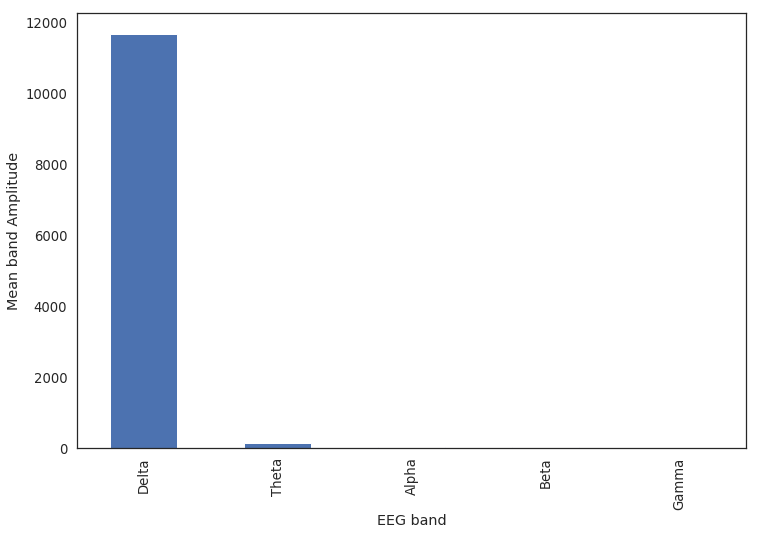

In [7]:
# Plot the data (using pandas here cause it's easy)
df = pd.DataFrame(columns=['band', 'val'])
df['band'] = ['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma']
df['val'] = [delta_power, theta_power, alpha_power, beta_power, gamma_power]
ax = df.plot.bar(figsize=(12, 8), x='band', y='val', legend=False)
ax.set_xlabel("EEG band")
ax.set_ylabel("Mean band Amplitude")